In [1]:
import cv2
import numpy as np
import math
from scipy.spatial import distance as dist
import pandas as pd


# Parametros para lk_track

# problemas actuales:
*detectar cual marcador corresponde con el siguiente en la deteccion

*analizar hacia adonde se dirige el flujo

In [7]:
#Importar video

fileName='est 2.avi'
cap = cv2.VideoCapture(fileName)

cantidadFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

font = cv2.FONT_HERSHEY_SIMPLEX

## convert your array into a dataframe
#df = pd.DataFrame (np.zeros([1]), columns=list('A'))

#por que se usa un tipo de video sin ningun tipo de estabilizacion, 
#el codigo funciona mejor con una cantidad muy limitada de frames


skipframes=0
#saltea una cantidad x de frames al inicio


#numero de frames que saltea al inicio
while(skipframes):
    cap.read()
    skipframes-=1
    
    
while(1):
    # Take first frame and find corners in it
    #ret, old_frame = cap.read()

    
    #Capturamos una imagen y la convertimos de RGB -> HSV
    ret,frame = cap.read()
    
    if 0==ret:#frame nulo
        break
            
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
 
    #Establecemos el rango de colores que vamos a detectar
    #En este caso de verde oscuro a verde-azulado claro
    #blanco_bajos = np.array([200,200,200], dtype=np.uint8)
    #blanco_altos = np.array([255, 255, 255], dtype=np.uint8)
    blanco_bajos_hsv = np.array([0,0,180], dtype=np.uint8)
    blanco_altos_hsv = np.array([50, 50, 255], dtype=np.uint8)
    
    
    #Crear una mascara con solo los pixeles dentro del rango de verdes
    #mask2 = cv2.inRange(frame, blanco_bajos, blanco_altos)
    mask = cv2.inRange(hsv, blanco_bajos_hsv, blanco_altos_hsv)
    
    ###################################################   
    #Buscar las rectas que componen cada ola
    #Hough transform
    
    src=mask
    
    dst = cv2.Canny(src, 50, 200, None, 3)

    # Copy edges to the images that will display the results in BGR
    cdstP = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    sup = np.copy(frame)
    finales = np.copy(frame)

    linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 30, 10)

            
    angProm=np.zeros(len(linesP))
    angProm[:]=np.angle(linesP[:,0,2]-linesP[:,0,0]+linesP[:,0,3]*1j-linesP[:,0,1]*1j, deg=True)

    angMedian=np.median(angProm) 
    linesSave=np.zeros((linesP.shape))
    linesSaveExpanse=np.zeros((linesP.shape))
    linesDistanceWithpreviousLine=np.zeros([np.int(linesP[:,0,0].shape[0]),2])
    linesDistanceWithpreviousLineFiltradas=np.zeros([np.int(linesP[:,0,0].shape[0]),2])
    
    lineNew=np.zeros([2,2])
    lineOld=np.zeros([2,2])
    lineCont=0
    lineContF=0
    
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
            cv2.line(sup, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
            
            #dibuja las lineas que tienen un angulo proximo a la media de las lineas encontradas en total
            angle =np.angle(l[2]-l[0]+l[3]*1j-l[1]*1j, deg=True)
            if angle<=(angMedian+10) and angle>=(angMedian-10):
                cv2.line(sup, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv2.LINE_AA)
                linesSave[lineCont]=linesP[i][0]
                
                if np.tan(angMedian*np.pi/180)*(1080-linesSave[lineCont,0,0])+linesSave[lineCont,0,1]<=1920:
                    linesSaveExpanse[lineCont]=[linesSave[lineCont,0,0],linesSave[lineCont,0,1],1080,np.tan(angMedian*np.pi/180)*(1080-linesSave[lineCont,0,0])+linesSave[lineCont,0,1]]
                    
                    
                elif ((1920-linesSave[lineCont,0,1])/np.tan(angMedian*np.pi/180))+linesSave[lineCont,0,0]<=1080:
                    
                    linesSaveExpanse[lineCont]=[linesSave[lineCont,0,0],linesSave[lineCont,0,1],((1920-linesSave[lineCont,0,1])/np.tan(angMedian*np.pi/180))+linesSave[lineCont,0,0],1920]
                    
                linesSaveExpanse = linesSaveExpanse[(-linesSaveExpanse[:,0,3]).argsort()]

                if lineCont>=1:
                    lineNew[0]=[linesSaveExpanse[lineCont,0,0],linesSaveExpanse[lineCont,0,1]]
                    lineNew[1]=[linesSaveExpanse[lineCont,0,2],linesSaveExpanse[lineCont,0,3]]
                    lineOld[0]=[linesSaveExpanse[lineCont-1,0,0],linesSaveExpanse[lineCont-1,0,1]]
                    lineOld[1]=[linesSaveExpanse[lineCont-1,0,2],linesSaveExpanse[lineCont-1,0,3]]
                    
                    linesDistanceWithpreviousLine[lineCont]=np.divide(np.cross([lineNew[0],lineNew[1]], [lineNew[1],lineOld[1]]),np.linalg.norm(lineNew))
                    #linesDistanceWithpreviousLine[lineCont]=-lineNew[1,1]+lineOld[1,1]
                
                    if linesDistanceWithpreviousLine[lineCont,1]!=linesDistanceWithpreviousLine[lineCont-1,1]:
                        if linesDistanceWithpreviousLine[lineCont,1]>5 or linesDistanceWithpreviousLine[lineCont,1]<-5:


                            cv2.line(finales, (np.int(lineNew[1,0]), np.int(lineNew[1,1])), (np.int(lineOld[1,0]), np.int(lineOld[1,1])), (255,0,0), 3, cv2.LINE_AA)

                            cv2.line(finales, (np.int(lineNew[0,0]), np.int(lineNew[0,1])), (np.int(lineNew[1,0]), np.int(lineNew[1,1])), (0,255,0), 3, cv2.LINE_AA)
                            cv2.line(finales, (np.int(lineOld[0,0]), np.int(lineOld[0,1])), (np.int(lineOld[1,0]), np.int(lineOld[1,1])), (0,255,0), 3, cv2.LINE_AA)
                            
                            cv2.putText(finales,str(linesDistanceWithpreviousLine[lineCont,1]),(np.int(lineNew[1,0]), np.int(lineNew[1,1])), font, 0.75,(255,255,255),2,cv2.LINE_AA)
                            
                            linesDistanceWithpreviousLineFiltradas[lineContF]=linesDistanceWithpreviousLine[lineCont]
                            lineContF+=1
                
                lineCont+=1
                
    #########buscar la distancia perpendicular a la recta ente las rectas, ignorando las rectas que se encuantrean a la misma distancia
            
    #df2 = pd.DataFrame (linesDistanceWithpreviousLineFiltradas[linesDistanceWithpreviousLineFiltradas[:,0]!=0,0], columns=list('A'))
    #df=df.append(df2, ignore_index=True)
    #df=df.append(pd.DataFrame ([0], columns=list('A')), ignore_index=True)
    cv2.imshow("Source", src)
    cv2.imshow("Finales", finales)
    cv2.imshow("Superposicion", sup)
    #cv2.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)
    
    #cv2.imshow('mask HSV', mask)
    #cv2.imshow('mask RGB', mask2)
    #cv2.imshow('Frame', frame)
    
    
    
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

        
## convert your array into a dataframe

## save to xlsx file
#Guarda las longitudes de onda en un archivo xlsx


#filepath = 'longitudes de onda.xlsx'

#df.to_excel(filepath, index=False)

cv2.imwrite('Finales.png',finales)
cv2.destroyAllWindows()
cap.release()

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide


In [24]:
df.append(df2.append(df2))

,A
0,0.000000
0,-196.869869
1,-196.869869
2,-196.869869
3,-212.214033
4,-66.090684
5,-66.090684
6,-63.141242
7,-63.141242
8,-276.504817


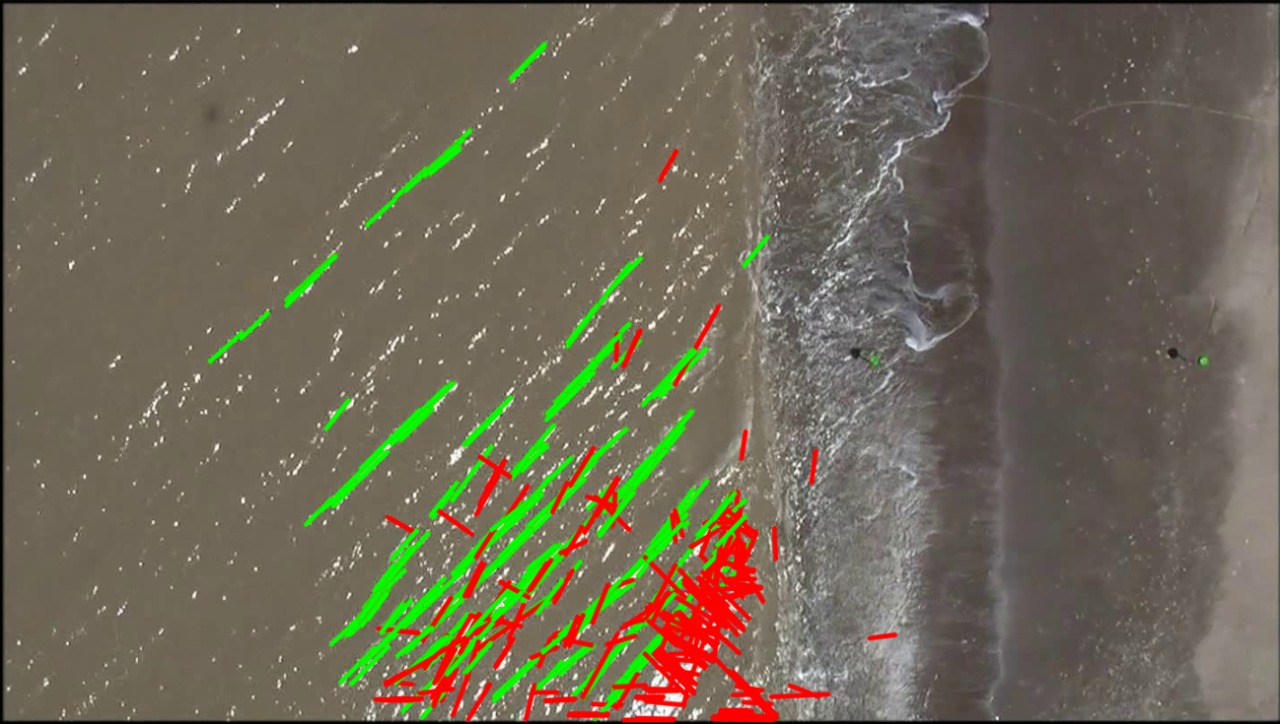

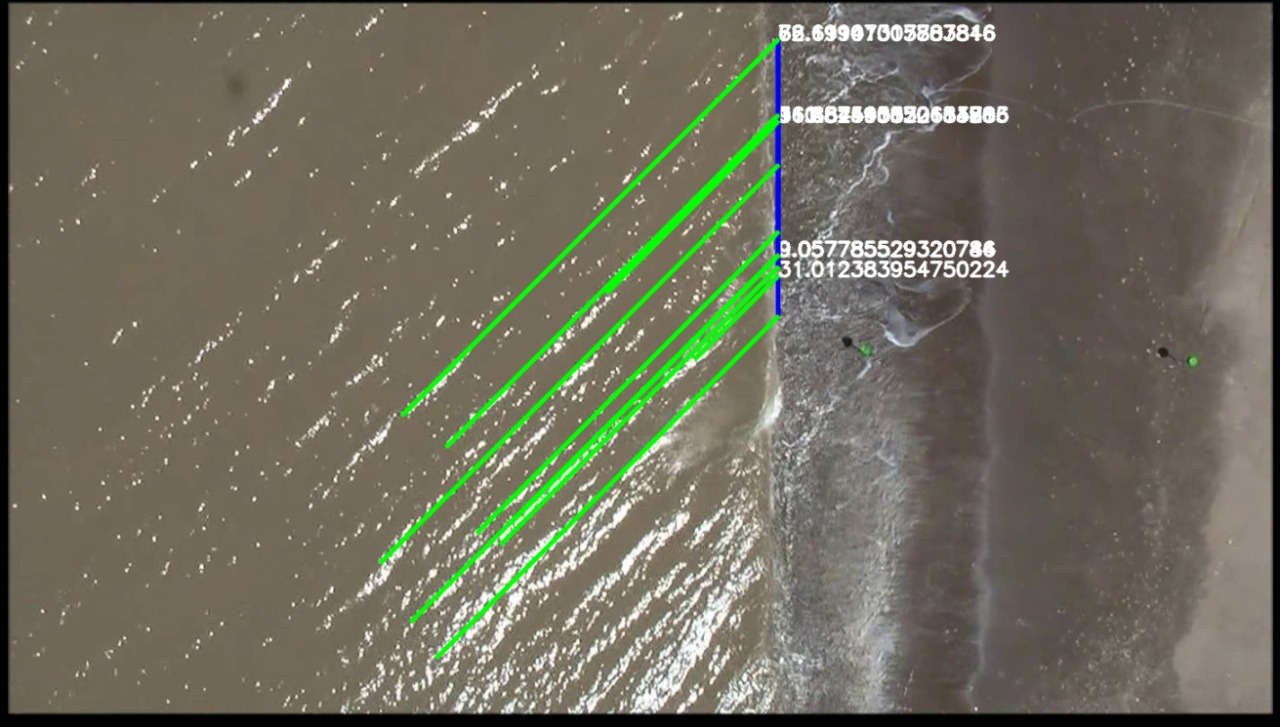

In [144]:
#funciona aceptablemente bien

a = [[20, 0], [50, 0]]
b = [[5, 1], [10, 1]]
c=np.divide(np.cross(a, [a[0],b[0]]),np.linalg.norm(a))
c

array([0.        , 0.92847669])

In [31]:
nlineas, v, coor=linesP.shape

lineasDosDimen1=np.zeros([nlineas,2])
lineasDosDimen2=np.zeros([nlineas,2])

lineasDosDimen1[:,0]=linesP[:,0,0]
lineasDosDimen1[:,1]=linesP[:,0,1]
lineasDosDimen2[:,0]=linesP[:,0,2]
lineasDosDimen2[:,1]=linesP[:,0,3]

distancia1=dist.pdist(lineasDosDimen1, metric='euclidean')  
distancia1.shape

(28920,)

In [6]:
#RGB to HSV

green = np.uint8([[[255,255,255 ]]])
hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
print( hsv_green )

[[[  0   0 255]]]


In [2]:
####Funciones
def buscarMasCercano( mask, memoria, fila, columna, puntos, contadorPuntos ):
    for xfila in range(-5,5):
        for xcolumna in range(-5,5):
            if memoria[fila+xfila, columna+xcolumna]==1:
                memoria[fila+xfila, columna+xcolumna]=0

                if mask[fila, columna]==255:
                    contadorPuntos+=1
                    puntos[contadorPuntos]=fila,columna
                    buscarMasCercano( mask, memoria, fila+xfila, columna+xcolumna, puntos, contadorPuntos )

    return

In [5]:
import cv2
import numpy as np
####Funciones
def buscarMasCercano( mask, memoria, fila, columna, puntos, contadorPuntos ):
    for xfila in range(-5,5):
        for xcolumna in range(-5,5):
            if memoria[fila+xfila, columna+xcolumna]==1:
                memoria[fila+xfila, columna+xcolumna]=0

                if mask[fila, columna,0]==255:
                    contadorPuntos+=1
                    puntos[contadorPuntos]=fila,columna
                    buscarMasCercano( mask, memoria, fila+xfila, columna+xcolumna, puntos, contadorPuntos )

    return

frame=cv2.imread("mask.png")
mask=cv2.imread("mask.png")

filas, columnas =frame[:,:,0].shape
memoria=np.zeros(frame[:,:,0].shape)
memoria[:,:]=1
puntos=np.zeros([3000,2])
rectasPuntos=np.zeros([2000,3000,2])
#frameRectas=np.zeros([cantidadFrames,1000,3000,2])
contadorPuntos=0
contadorRectas=0

##recorro la mascara de luminancia para hayar las rectas de las olas
for fila in range (0, filas):
    for columna in range (0, columnas):
        if memoria[fila, columna]==1:
            memoria[fila, columna]=0
            if mask[fila, columna,0]==255:

                contadorPuntos=0
                puntos[:]=0,0
                puntos[contadorPuntos]=fila,columna

                ##busco el siguiente punto mas cercano en un radio de 10 pixeles
                buscarMasCercano( mask, memoria, fila, columna, puntos, contadorPuntos)
                rectasPuntos[contadorRectas]=puntos
                contadorRectas+=1


#frameRectas[actualFrame]=rectasPuntos             


In [13]:
canvas=np.zeros([1080,1920,3])

for rectas in range(0,2000):
    for puntos in range(0,3000):
        if rectasPuntos[rectas,puntos,0]!=0:
            canvas[np.int(rectasPuntos[rectas,puntos,0]),np.int(rectasPuntos[rectas,puntos,1])]=(255,255,255)
            
    
    cv2.imshow('Canvas', canvas)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
            


In [10]:
#Hough transform
import sys
import math
import cv2 as cv
import numpy as np


default_file =  "mask.png"
filename = default_file
# Loads an image
src = cv.imread(filename, cv.IMREAD_GRAYSCALE)
# Check if image is loaded fine



dst = cv.Canny(src, 50, 200, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)


linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

cv.imshow("Source", src)
cv.imshow("Detected Lines (in red) - Standard Hough Line Transform", cdst)
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)

cv.waitKey()

27

In [67]:
import xlsxwriter

workbook = xlsxwriter.Workbook('arrays.xlsx')
worksheet = workbook.add_worksheet()

array = [['a1', 'a2', 'a3'],
         ['a4', 'a5', 'a6'],
         ['a7', 'a8', 'a9'],
         ['a10', 'a11', 'a12', 'a13', 'a14']]

f, c =rectasPuntos[:,:,0].shape

for row in range(0,f):
    for col in range(0,c):
        worksheet.write(row, col, np.int(rectasPuntos[row,col,0]))

workbook.close()

In [4]:
import pandas as pd

## convert your array into a dataframe
df = pd.DataFrame (rectasPuntos[:,:,0])
df2 = pd.DataFrame (rectasPuntos[:,:,1])

## save to xlsx file

filepath = 'my_excel_file.xlsx'
filepath2 = 'my_excel_file2.xlsx'

df.to_excel(filepath, index=False)
df2.to_excel(filepath2, index=False)

In [62]:
np.int(rectasPuntos[0,0,0])

0

In [ ]:
segmentar por luminancia
hough  HUE
ver longitud de onda